In [7]:
# Load raw data
from pandas import read_csv
from datetime import datetime, timedelta
from timeit import default_timer
import pandas as pd

df_team_bx = read_csv('data/team_boxscore_stats_1997-19.csv')
df_player_bx = read_csv('data/player_boxscore_stats_1997-19_adv.csv')
    

In [14]:
import pandas as pd
import os

import numpy as np
from pandas import read_csv
from datetime import datetime, timedelta
from timeit import default_timer


def features():
    features_type = {
        'H_RD': int,  # Rest days
        # 'H_WR': float, # Win ratio for last 10 games
        'H_WLG': bool,  # Won last game
        'H_EFG': float,  # Effective field goal %
        'H_OREB': float,  # Offesnie RB %
        'H_DREB': float,  # Defensive RB %
        'H_AST_TO': float,  # Assit to Turn over ratio
        # 'H_W': float,  # win percentage
        'A_RD': int,  # Rest days
        # 'A_WR': float, # Win ratio for last 10 games
        'A_WLG': bool,  # Won last game
        'A_EFG': float,  # Effective field goal %
        'A_OREB': float,  # Offesnie RB %
        'A_DREB': float,  # Defensive RB %
        'A_AST_TO': float,  # Assit to Turn over ratio
        # 'A_W': float  # win percentage
    }
    return features_type


def check_court(match):
    return AWAY if match.split()[1] == '@' else HOME


def check_winner(game_inf):
    court = check_court(game_inf['MATCHUP'])
    if court == HOME:
        winner = HOME if game_inf['WL'] == 'W' else AWAY
    else:
        winner = AWAY if game_inf['WL'] == 'W' else HOME

    return winner


def guess_starters(players_bx, game_inf):
    return players_bx[(players_bx.GAME_ID == game_inf['GAME_ID'])
                      & (players_bx.TEAM_ID == game_inf['TEAM_ID'])].head(
        NUM_PLAYERS).sort_values(
        by='MIN', ascending=False)  # TODO: clean this


def assign_features(sample, game_inf, teams_meta, player_stats):
    court_prefix = check_court(game_inf['MATCHUP']) + "_"
    game_id, team_id = game_inf['GAME_ID'], game_inf['TEAM_ID']
    game_date = datetime.strptime(game_inf['GAME_DATE'][:10], '%Y-%m-%d')
    weights = player_stats['MIN'] / (player_stats['MIN'].sum())

    sample.update({
        court_prefix + 'RD': (game_date - teams_meta[team_id]['last_game_dt']).days,
        court_prefix + 'WLG': teams_meta[team_id]['WLG'],
        court_prefix + 'EFG': (weights * player_stats['EFG_PCT']).sum(),
        court_prefix + 'OREB': (weights * player_stats['OREB_PCT']).sum(),
        court_prefix + 'DREB': (weights * player_stats['DREB_PCT']).sum(),
        court_prefix + 'AST_TO': (weights * player_stats['AST_TO']).sum(),
        court_prefix + 'W_PCT': (weights * player_stats['W_PCT']).sum()
    })

In [14]:
"""
DEFINITIONS
"""
HOME = 'H'
AWAY = 'A'


"""
SETTINGS 
"""
NUM_PLAYERS = 10  # Number of players used to generate features
REQ_PLAYER_STATS = [
    "PLAYER_ID",
    "PLAYER_NAME",
    "OREB_PCT",
    "DREB_PCT",
    "EFG_PCT",
    "AST_TO",
    "W_PCT",
    "MIN"
]


"""
SCRIPT
"""
abs_path = os.getcwd()
df_team_bx = read_csv(abs_path + '/data/team_boxscore_stats_1997-19.csv')
df_player_bx = read_csv(abs_path + '/data/player_boxscore_stats_1997-19_adv.csv')


start_time = default_timer()
x_train = list()
y_train = list()
season_id = None
incomplete_sample = dict()  # {'%ID": %i}

for i, game_inf in df_team_bx.iterrows():

    # Fetch last seasons player stats
    if season_id != game_inf['SEASON_ID']:  #TODO: Season 1999 splits regular/playoff
        season_id = game_inf['SEASON_ID']
        teams_meta = dict()
        yr = game_inf['GAME_DATE'][:4]
        file_path ='data/player_yearly_stats/player_stats_' + str(int(yr) - 1)[-2:] + '-' + yr[-2:] + '.csv'
        df_player_stats_hist = read_csv(file_path)
        print('Processing Season' + yr + '...')

    game_id, team_id = game_inf['GAME_ID'], game_inf['TEAM_ID']
    if not teams_meta.get(team_id):
        teams_meta[team_id] = {
            'last_game_dt': datetime.strptime(game_inf['GAME_DATE'][:10], '%Y-%m-%d'),
            'WLG': True if game_inf['WL'] == 'W' else False
        }
        continue

    # TODO: implement winning streaks
    # if len(teams_meta.get(team_id, {}).get(last_5_games, [])) < 5:
    #     team_meta[team_id]['last_5_games'] = team_meta[team_id].get('last_5_games',[]) + []
    #     continue

    if game_id in incomplete_sample:
        sample = x_train[incomplete_sample[game_id]]
        incomplete_sample.pop(game_id)
    else:
        sample = features()
        x_train.append(sample)
        y_train.append(check_winner(game_inf))
        incomplete_sample[game_id] = len(x_train) - 1

    starters = guess_starters(df_player_bx, game_inf)
    starters_stats = df_player_stats_hist.merge(starters, on='PLAYER_ID', how='right', suffixes=('', '_BX'))

    # TODO: Assign residual stats, deal with non-existent stats
    # if not avg_stats:
    #     # do not overwrite
    #     player_stats = df_player_stats_cur[df_player_stats_cur.PLAYER_ID == player['PLAYER_ID']]

    assign_features(sample, game_inf, teams_meta, starters_stats)
    teams_meta[team_id] = {
        'last_game_dt': datetime.strptime(game_inf['GAME_DATE'][:10], '%Y-%m-%d'),
        'WLG': True if game_inf['WL'] == 'W' else False
    }

print('Cleaning incomplete samples...')

# Clean throw away data
for i in sorted(list(incomplete_sample.values()), reverse=True):
    x_train.pop(i)
    y_train.pop(i)

end_time = default_timer()
print(len(x_train), 'Samples Generated in', timedelta(seconds=end_time - start_time))

add_info = str(NUM_PLAYERS) + 'P'
add_info += '_' if add_info else ''
time_lbl = datetime.now().strftime('%m-%d-%H%M%S')

feat_file = abs_path + '/feature_data/x_train_' + add_info + time_lbl
lbl_file = abs_path + '/feature_data/y_train_' + add_info + time_lbl

np.save(feat_file, pd.DataFrame(x_train).values)
np.save(lbl_file, y_train)

print('Training data generated in feature_data folder')

Processing Season1997...
Cleaning incomplete samples...
99  Samples Generated in  0:00:01.964518


In [2]:
import os
import glob
from time import time

import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier


def train_classifier(clf, x_train, y_train):
    ''' Fits a classifier to the training data. '''

    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(x_train, y_train)
    end = time()

    # Print the results
    print(f"Trained model in {round(end - start, 3)} seconds")


def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on F1 score. '''

    y_pred = clf.predict(features)
    return f1_score(target, y_pred, pos_label='H'), sum(target == y_pred) / float(len(y_pred))


def train_predict(clf, x_train, y_train, x_test, y_test):
    ''' Train and predict using a classifer based on F1 score. '''

    # Indicate the classifier and the training set size
    print(f"Training a {clf.__class__.__name__} using a training set size of {len(x_train)}. . .")

    # Train the classifier
    train_classifier(clf, x_train, y_train)

    # Print the results of prediction for both training and testing
    f1, acc = predict_labels(clf, x_train, y_train)
    print(f1, acc)
    print(f"F1 score and accuracy score for training set: {f1} , {np.mean(acc)}.")

    f1, acc = predict_labels(clf, x_test, y_test)
    print(f"F1 score and accuracy score for test set: {f1} , {np.mean(acc)}.")

In [2]:
LATEST_DATA = False
source_file = ''

data_folder = '/feature_data/'
folder_path = os.getcwd() + data_folder
if not LATEST_DATA:
    feature_file = max(glob.iglob(folder_path + '*x_train*'), key=os.path.getctime)
    lbl_file = max(glob.iglob(folder_path + '*y_train*'), key=os.path.getctime)
elif not source_file:
    raise Exception("Source file name must be specified, assign to 'source_file' var")

features = np.load(feature_file)
labels = np.load(lbl_file)

x_train, x_test, y_train, y_test = \
    train_test_split(features,
                     labels,
                     test_size=0.2,
                     random_state=2,
                     stratify=labels)

clf_A = LogisticRegression(random_state=42, solver='saga', max_iter=999999)
train_predict(clf_A, x_train, y_train, x_test, y_test)
print('')

clf_B = SVC(random_state=912, kernel='rbf', gamma='auto')
train_predict(clf_B, x_train, y_train, x_test, y_test)
print('')

clf_C = KNeighborsClassifier(n_neighbors=8)
train_predict(clf_C, x_train, y_train, x_test, y_test)
print('')

clf_D = LinearDiscriminantAnalysis()
train_predict(clf_D, x_train, y_train, x_test, y_test)
print('')

clf_E = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
train_predict(clf_E, x_train, y_train, x_test, y_test)
print('')

clf_F = XGBClassifier()
train_predict(clf_F, x_train, y_train, x_test, y_test)

Training a LogisticRegression using a training set size of 20555. . .
Trained model in 3.01 seconds
0.7394535519125682 0.6520554609584043
F1 score and accuracy score for training set: 0.7394535519125682 , 0.6520554609584043.
F1 score and accuracy score for test set: 0.7355685131195334 , 0.6470130375559447.

Training a SVC using a training set size of 20555. . .
Trained model in 17.416 seconds
0.7515574214517877 0.6430065677450741
F1 score and accuracy score for training set: 0.7515574214517877 , 0.6430065677450741.
F1 score and accuracy score for test set: 0.746673834162075 , 0.6331971200622689.

Training a KNeighborsClassifier using a training set size of 20555. . .
Trained model in 0.289 seconds
0.740139211136891 0.6948674288494283
F1 score and accuracy score for training set: 0.740139211136891 , 0.6948674288494283.
F1 score and accuracy score for test set: 0.6423333333333333 , 0.5824090289939677.

Training a LinearDiscriminantAnalysis using a training set size of 20555. . .
Trained 

[0.08151383 0.10189229 0.11353712 0.05676856 0.02328967 0.02037846
 0.12663755 0.08151383 0.09752547 0.08733624 0.04803494 0.02037846
 0.02037846 0.12081514]


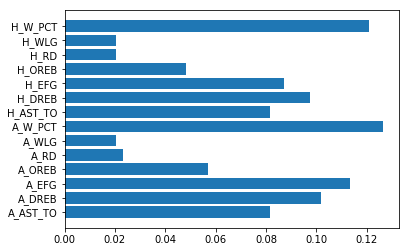

In [31]:
import copy
labels = ['A_AST_TO', 'A_DREB', 'A_EFG', 'A_OREB', 'A_RD', 'A_WLG', 'A_W_PCT',
       'H_AST_TO', 'H_DREB', 'H_EFG', 'H_OREB', 'H_RD', 'H_WLG', 'H_W_PCT']

feature_imp = copy.deepcopy(model.feature_importances_)
print(feature_imp)
pyplot.barh(range(len(model.feature_importances_)), model.feature_importances_, tick_label=labels )
pyplot.show()



In [4]:
# plot feature importance manually
from numpy import loadtxt
from xgboost import XGBClassifier
from matplotlib import pyplot
import numpy as np
from sklearn.feature_selection import SelectFromModel

labels = ['A_AST_TO', 'A_DREB', 'A_EFG', 'A_OREB', 'A_RD', 'A_WLG', 'A_W_PCT',
       'H_AST_TO', 'H_DREB', 'H_EFG', 'H_OREB', 'H_RD', 'H_WLG', 'H_W_PCT']
x_train = np.load('feature_data/x_train_10P_04-15-232419.npy')
y_train = np.load('feature_data/y_train_10P_04-15-232419.npy')

X_train, X_test, Y_train, y_test = train_test_split(pd.DataFrame(x_train).values, np.array(y_train), 
                                                    test_size = 0.2,
                                                    random_state = 2,
                                                    stratify = np.array(y_train))

# fit model no training data
model = XGBClassifier()
model.fit(X_train, Y_train)

y_pred = model.predict(X_test)
sum(y_test == y_pred) / float(len(y_pred))

0.6553804242070441

In [47]:
thresh = 0.05

selection = SelectFromModel(model, threshold=thresh, prefit=True)
select_X_train = selection.transform(X_train)
# train model
selection_model = XGBClassifier()
selection_model.fit(select_X_train, Y_train)
# eval model
select_X_test = selection.transform(X_test)
y_pred = selection_model.predict(select_X_test)
sum(y_test == y_pred) / float(len(y_pred))

0.6520723876240514

In [5]:
np.array(['cunt'])

array(['cunt'], dtype='<U4')

In [15]:
pd.DataFrame(x_train).columns

Index(['A_AST_TO', 'A_DREB', 'A_EFG', 'A_OREB', 'A_RD', 'A_WLG', 'A_W_PCT',
       'H_AST_TO', 'H_DREB', 'H_EFG', 'H_OREB', 'H_RD', 'H_WLG', 'H_W_PCT'],
      dtype='object')